<a href="https://colab.research.google.com/github/MikeSirya/Master-Thesis/blob/main/LSTM_Nested_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np

import  tensorflow.keras.losses

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/Castellon Baynat21.csv"

df = pd.read_csv(csv_path)
df

,Timestamp,Castelló de la Plana - IES Vicent Sos Baynat
0,01/01/2021 00:00,10.6
1,01/01/2021 00:10,10.7
2,01/01/2021 00:20,10.5
3,01/01/2021 00:30,10.4
4,01/01/2021 00:40,10.4
...,...,...
21739,31/05/2021 23:10,20.8
21740,31/05/2021 23:20,20.8
21741,31/05/2021 23:30,20.7
21742,31/05/2021 23:40,20.7


In [ ]:
df.index = pd.to_datetime(df['Timestamp'], format= "%d/%m/%Y %H:%M")
df[:5]

,Timestamp,Castelló de la Plana - IES Vicent Sos Baynat
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,10.6
2021-01-01 00:10:00,01/01/2021 00:10,10.7
2021-01-01 00:20:00,01/01/2021 00:20,10.5
2021-01-01 00:30:00,01/01/2021 00:30,10.4
2021-01-01 00:40:00,01/01/2021 00:40,10.4


In [ ]:
df.index = pd.to_datetime(df['Timestamp'], format= "%d/%m/%Y %H:%M")
df[:5]

,Timestamp,Castelló de la Plana - IES Vicent Sos Baynat
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,10.6
2021-01-01 00:10:00,01/01/2021 00:10,10.7
2021-01-01 00:20:00,01/01/2021 00:20,10.5
2021-01-01 00:30:00,01/01/2021 00:30,10.4
2021-01-01 00:40:00,01/01/2021 00:40,10.4


In [ ]:
df.tail()

,Timestamp,Castelló de la Plana - IES Vicent Sos Baynat
Timestamp,,
2021-05-31 23:10:00,31/05/2021 23:10,20.8
2021-05-31 23:20:00,31/05/2021 23:20,20.8
2021-05-31 23:30:00,31/05/2021 23:30,20.7
2021-05-31 23:40:00,31/05/2021 23:40,20.7
2021-05-31 23:50:00,31/05/2021 23:50,20.6


In [ ]:
import pandas as pd

# Assuming df is your DataFrame
num_rows = len(df)
print("Number of rows:", num_rows)


Number of rows: 21744


<Axes: xlabel='Timestamp'>

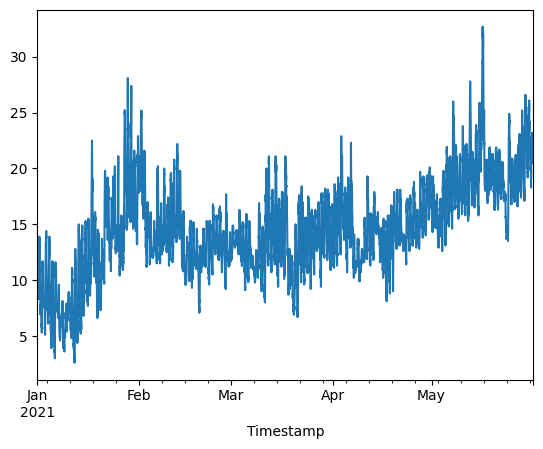

In [ ]:
temp = df['Castelló de la Plana - IES Vicent Sos Baynat']
temp.plot()

In [ ]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((21739, 5, 1), (21739,))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Assuming you have already defined your df_to_X_y function and loaded your data

# Features (X) and Target Variable (y) using df_to_X_y
WINDOW_SIZE = 5
X, y = df_to_X_y(temp, WINDOW_SIZE)

# Nested Cross-Validation
tscv_outer = TimeSeriesSplit(n_splits=5)
tscv_inner = TimeSeriesSplit(n_splits=3)

param_grid = {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20]}

outer_scores = []

for train_outer, test_outer in tscv_outer.split(X):
    X_train_outer, X_test_outer = X[train_outer], X[test_outer]
    y_train_outer, y_test_outer = y[train_outer], y[test_outer]

    inner_scores = []

    for train_inner, val_inner in tscv_inner.split(X_train_outer):
        X_train_inner, X_val_inner = X_train_outer[train_inner], X_train_outer[val_inner]
        y_train_inner, y_val_inner = y_train_outer[train_inner], y_train_outer[val_inner]

        # Reshape the input data for LSTM
        X_train_inner_reshaped = X_train_inner.reshape(X_train_inner.shape[0], X_train_inner.shape[1], 1)
        X_val_inner_reshaped = X_val_inner.reshape(X_val_inner.shape[0], X_val_inner.shape[1], 1)

        # Build and compile the model
        model1 = Sequential()
        model1.add(InputLayer((5, 1)))
        model1.add(LSTM(64))
        model1.add(Dense(8, 'relu'))
        model1.add(Dense(1, 'linear'))

        model1.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

        # Train the model on the inner training set
        model1.fit(
            X_train_inner_reshaped, y_train_inner,
            epochs=10,  # Adjust the number of epochs
            batch_size=32,  # Adjust the batch size
            verbose=0  # Adjust verbosity as needed
        )

        # Evaluate the model on the inner validation set
        X_val_inner_reshaped = X_val_inner.reshape(X_val_inner.shape[0], X_val_inner.shape[1], 1)
        y_pred_val = model1.predict(X_val_inner_reshaped)

        mse_inner = mean_squared_error(y_val_inner, y_pred_val)
        inner_scores.append(mse_inner)

    # Get the mean inner score for hyperparameter tuning
    mean_inner_score = np.mean(inner_scores)

    # Flatten the X_test_outer array for final evaluation
    X_test_outer_reshaped = X_test_outer.reshape(X_test_outer.shape[0], X_test_outer.shape[1], 1)

    # Evaluate the model on the outer test set
    y_pred_outer = model1.predict(X_test_outer_reshaped)

    # Calculate the mean squared error for the outer fold
    mse_outer = mean_squared_error(y_test_outer, y_pred_outer)

    print(f'Mean Squared Error for Outer Fold: {mse_outer}')

    # Store the outer score for aggregation
    outer_scores.append(mse_outer)

# Calculate and print the overall performance across all outer folds
print(f'Overall Mean Squared Error: {np.mean(outer_scores)}')


114/114 [==============================] - 0s 3ms/step
Mean Squared Error for Outer Fold: 0.49262382003395344
114/114 [==============================] - 0s 4ms/step
Mean Squared Error for Outer Fold: 0.06875028879630632
114/114 [==============================] - 1s 7ms/step
Mean Squared Error for Outer Fold: 0.0709683090143021
114/114 [==============================] - 0s 3ms/step
Mean Squared Error for Outer Fold: 0.056141303241089874
114/114 [==============================] - 0s 3ms/step
Mean Squared Error for Outer Fold: 0.416779717109767
Overall Mean Squared Error: 0.22105268763908376


In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [ ]:
# Save the trained model
model1.save('/content/model1')

# Load the saved model
loaded_model = load_model('/content/model1')



In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
train_predictions = loaded_model.predict(X_train_inner_reshaped).flatten()
train_rmse = sqrt(mean_squared_error(y_train_inner, train_predictions))
train_results = pd.DataFrame(data={'Actuals':y_train_inner,'Train Predictions':train_predictions, 'RMSE': [train_rmse] * len(y_train_inner)})
train_results

425/425 [==============================] - 2s 4ms/step


,Actuals,Train Predictions,RMSE
0,10.3,10.369363,0.269445
1,9.8,10.254630,0.269445
2,9.8,9.632449,0.269445
3,10.0,9.722232,0.269445
4,10.0,10.021147,0.269445
...,...,...,...
13582,12.8,12.370901,0.269445
13583,13.3,13.041771,0.269445
13584,13.1,13.523432,0.269445
13585,13.3,13.091177,0.269445


Text(0.5, 1.0, 'NESTED LSTM MODEL 2 ')

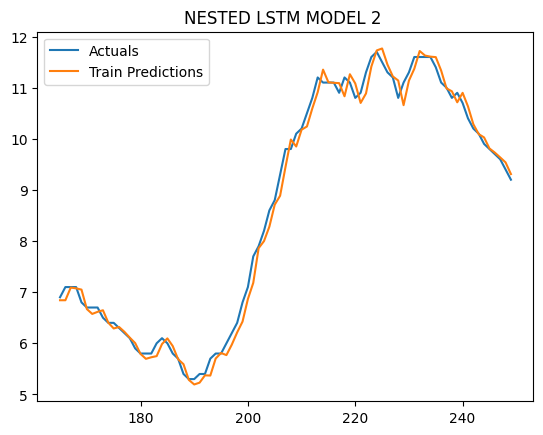

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Actuals'][165:250], label='Actuals')
plt.plot(train_results['Train Predictions'][165:250], label='Train Predictions')
plt.legend()
plt.title('NESTED LSTM MODEL 2 ')

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
val_predictions = loaded_model.predict(X_val_inner_reshaped).flatten()
val_rmse = sqrt(mean_squared_error(y_val_inner, val_predictions))
val_results = pd.DataFrame(data={'Actuals':y_val_inner,'val Predictions':val_predictions, 'RMSE': [val_rmse] * len(y_val_inner)})
val_results

142/142 [==============================] - 1s 4ms/step


,Actuals,val Predictions,RMSE
0,14.4,14.110524,0.240874
1,16.6,14.610141,0.240874
2,16.1,17.199463,0.240874
3,16.2,15.919991,0.240874
4,16.2,16.324633,0.240874
...,...,...,...
4524,19.9,20.173340,0.240874
4525,20.1,19.870331,0.240874
4526,19.5,20.173210,0.240874
4527,19.3,19.348221,0.240874


Text(0.5, 1.0, 'NESTED LSTM MODEL 2 ')

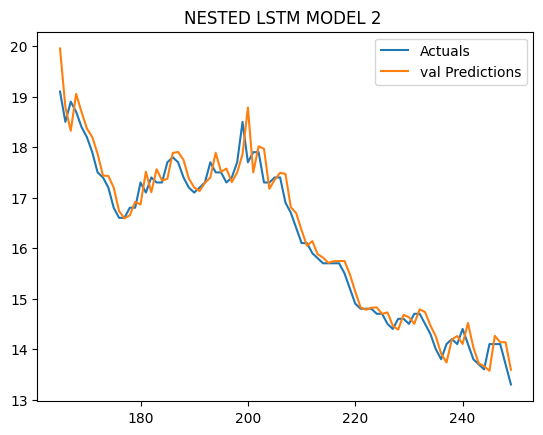

In [ ]:
import matplotlib.pyplot as plt
plt.plot(val_results['Actuals'][165:250], label='Actuals')
plt.plot(val_results['val Predictions'][165:250], label='val Predictions')
plt.legend()
plt.title('NESTED LSTM MODEL 2 ')

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
test_predictions = loaded_model.predict( X_test_outer_reshaped).flatten()
test_rmse = sqrt(mean_squared_error(y_test_outer, test_predictions))
test_results = pd.DataFrame(data={'Actuals':y_test_outer,'Test Predictions':test_predictions, 'RMSE': [test_rmse] * len(y_test_outer)})
test_results

114/114 [==============================] - 0s 4ms/step


,Actuals,Test Predictions,RMSE
0,18.8,18.819077,0.645585
1,18.7,18.819332,0.645585
2,18.6,18.728376,0.645585
3,18.2,18.632185,0.645585
4,18.0,18.137794,0.645585
...,...,...,...
3618,20.8,20.767239,0.645585
3619,20.8,20.793867,0.645585
3620,20.7,20.796671,0.645585
3621,20.7,20.673882,0.645585


In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/Castellon Bayanat22.csv"

val_df = pd.read_csv(csv_path)
val_df



,Timestamp,Castelló de la Plana - IES Vicent Sos Baynat
0,01/01/2021 00:00,9.7
1,01/01/2021 00:10,9.5
2,01/01/2021 00:20,9.3
3,01/01/2021 00:30,9.3
4,01/01/2021 00:40,9.1
...,...,...
21739,31/05/2021 23:10,21.3
21740,31/05/2021 23:20,21.2
21741,31/05/2021 23:30,21.2
21742,31/05/2021 23:40,21.3


In [ ]:
val_df.index = pd.to_datetime(val_df['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df[:5]

,Timestamp,Castelló de la Plana - IES Vicent Sos Baynat
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,9.7
2021-01-01 00:10:00,01/01/2021 00:10,9.5
2021-01-01 00:20:00,01/01/2021 00:20,9.3
2021-01-01 00:30:00,01/01/2021 00:30,9.3
2021-01-01 00:40:00,01/01/2021 00:40,9.1


<Axes: xlabel='Timestamp'>

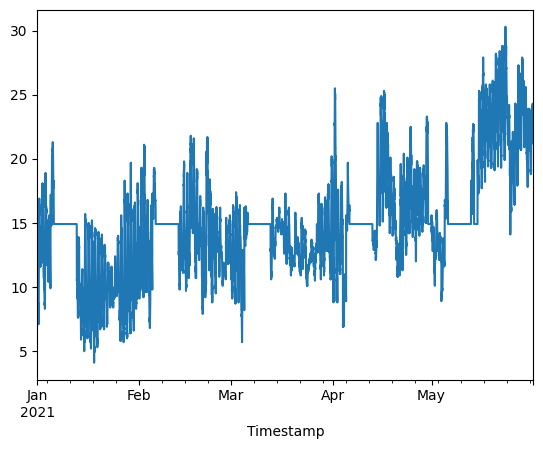

In [ ]:
val_df = val_df['Castelló de la Plana - IES Vicent Sos Baynat']
val_df.plot()

In [ ]:
# Assuming df_toX_y function extracts features (X) from the new data
WINDOW_SIZE = 5
X_new_data, y_new_data = df_to_X_y(val_df, WINDOW_SIZE)
# Access the shape of the features
X_new_data.shape, y_new_data.shape

((21739, 5, 1), (21739,))

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
Predictions = loaded_model.predict(X_new_data).flatten()
rmse1 = sqrt(mean_squared_error(y_new_data, Predictions))
Results = pd.DataFrame(data={'Actuals':y_new_data,'Predictions':Predictions, 'RMSE': [rmse1] * len(y_new_data)})
Results

680/680 [==============================] - 3s 5ms/step


,Actuals,Predictions,RMSE
0,8.8,9.017755,0.327706
1,8.4,8.675665,0.327706
2,8.1,8.227147,0.327706
3,8.2,7.931436,0.327706
4,8.3,8.137734,0.327706
...,...,...,...
21734,21.3,21.354994,0.327706
21735,21.2,21.267374,0.327706
21736,21.2,21.167543,0.327706
21737,21.3,21.187733,0.327706


Text(0.5, 1.0, 'NESTED LSTM MODEL 2 ')

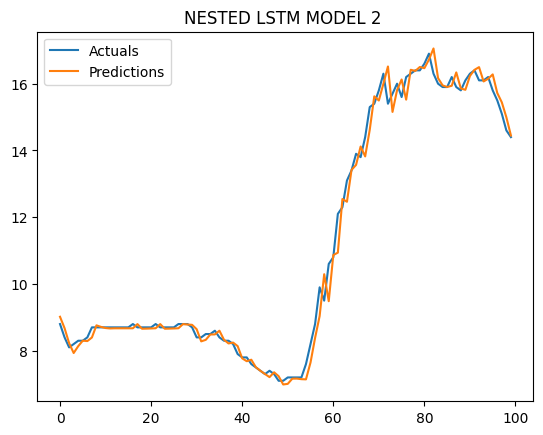

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Results['Actuals'][:100], label='Actuals')
plt.plot(Results['Predictions'][:100], label='Predictions')
plt.legend()
plt.title('NESTED LSTM MODEL 2 ')

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/Orpesa22.csv"

val_df2 = pd.read_csv(csv_path)
val_df2



,Timestamp,Orpesa Torre Bellver
0,01/01/2022 00:00,8.150000
1,01/01/2022 00:10,7.900000
2,01/01/2022 00:20,7.850000
3,01/01/2022 00:30,7.900000
4,01/01/2022 00:40,7.800000
...,...,...
21739,NaN,12.770466
21740,NaN,12.770466
21741,NaN,12.770466
21742,NaN,12.770466


In [ ]:
val_df2.index = pd.to_datetime(val_df2['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df2[:5]

,Timestamp,Orpesa Torre Bellver
Timestamp,,
2022-01-01 00:00:00,01/01/2022 00:00,8.15
2022-01-01 00:10:00,01/01/2022 00:10,7.90
2022-01-01 00:20:00,01/01/2022 00:20,7.85
2022-01-01 00:30:00,01/01/2022 00:30,7.90
2022-01-01 00:40:00,01/01/2022 00:40,7.80


<Axes: xlabel='Timestamp'>

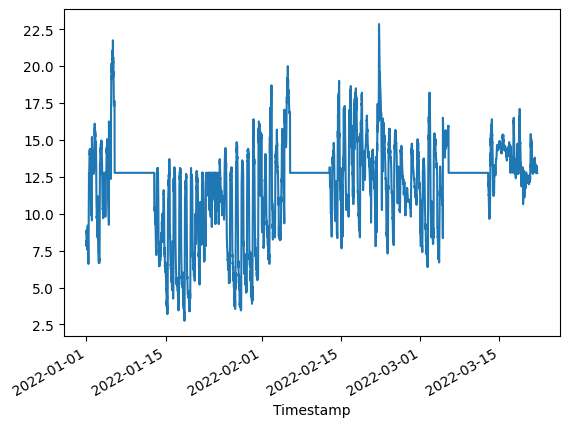

In [ ]:
val_df2 = val_df2['Orpesa Torre Bellver']
val_df2.plot()

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
num_rows = len(val_df2)
print("Number of rows:", num_rows)
val_df2.tail()

Number of rows: 21744


Timestamp
NaT    12.770466
NaT    12.770466
NaT    12.770466
NaT    12.770466
NaT    12.770466
Name: Orpesa Torre Bellver, dtype: float64

In [ ]:
# Assuming df_toX_y function extracts features (X) from the new data
WINDOW_SIZE = 5
X_new_data2, y_new_data2 = df_to_X_y(val_df2, WINDOW_SIZE)
# Access the shape of the features
X_new_data2.shape, y_new_data2.shape

((21739, 5, 1), (21739,))

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
Predictions2 = loaded_model.predict(X_new_data2).flatten()
rmse2 = sqrt(mean_squared_error(y_new_data2, Predictions2))
Results2 = pd.DataFrame(data={'Actuals':y_new_data2,'Predictions':Predictions2, 'RMSE': [rmse2] * len(y_new_data2)})
Results2

680/680 [==============================] - 3s 4ms/step


,Actuals,Predictions,RMSE
0,8.000000,7.740223,0.321283
1,8.350000,7.996610,0.321283
2,8.500000,8.432113,0.321283
3,8.850000,8.567193,0.321283
4,8.900000,8.943081,0.321283
...,...,...,...
21734,12.770466,12.779195,0.321283
21735,12.770466,12.779195,0.321283
21736,12.770466,12.779195,0.321283
21737,12.770466,12.779195,0.321283


Text(0.5, 1.0, 'NESTED LSTM MODEL 2 ')

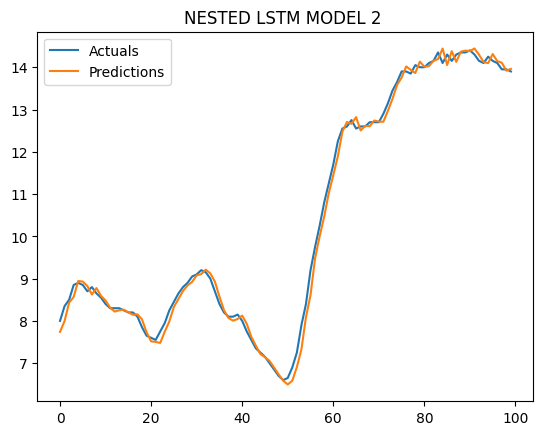

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Results2['Actuals'][:100], label='Actuals')
plt.plot(Results2['Predictions'][:100], label='Predictions')
plt.legend()
plt.title('NESTED LSTM MODEL 2 ')

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/SantMateu22.csv"

val_df3 = pd.read_csv(csv_path)
val_df3



,Timestamp,Sant Mateu
0,01/01/2021 00:00,6.15
1,01/01/2021 00:10,6.70
2,01/01/2021 00:20,6.85
3,01/01/2021 00:30,6.65
4,01/01/2021 00:40,6.55
...,...,...
21739,31/05/2021 23:10,17.75
21740,31/05/2021 23:20,17.80
21741,31/05/2021 23:30,17.70
21742,31/05/2021 23:40,16.45


In [ ]:
val_df3.index = pd.to_datetime(val_df3['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df3[:5]

,Timestamp,Sant Mateu
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,6.15
2021-01-01 00:10:00,01/01/2021 00:10,6.70
2021-01-01 00:20:00,01/01/2021 00:20,6.85
2021-01-01 00:30:00,01/01/2021 00:30,6.65
2021-01-01 00:40:00,01/01/2021 00:40,6.55


<Axes: xlabel='Timestamp'>

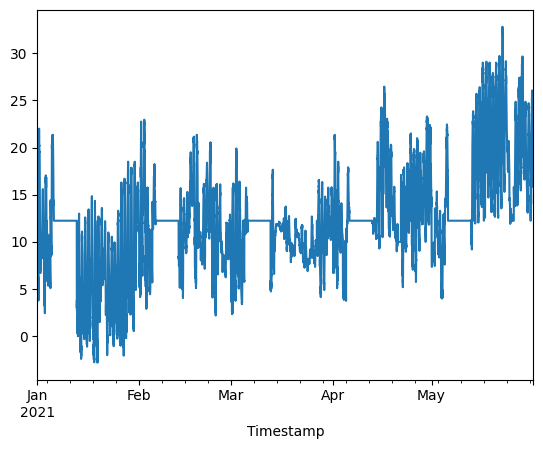

In [ ]:
val_df3 = val_df3['Sant Mateu']
val_df3.plot()

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
num_rows = len(val_df3)
print("Number of rows:", num_rows)
val_df3.tail()

Number of rows: 21744


Timestamp
2021-05-31 23:10:00    17.75
2021-05-31 23:20:00    17.80
2021-05-31 23:30:00    17.70
2021-05-31 23:40:00    16.45
2021-05-31 23:50:00    15.85
Name: Sant Mateu, dtype: float64

In [ ]:
# Assuming df_toX_y function extracts features (X) from the new data
WINDOW_SIZE = 5
X_new_data3, y_new_data3 = df_to_X_y(val_df3, WINDOW_SIZE)
# Access the shape of the features
X_new_data3.shape, y_new_data3.shape

((21739, 5, 1), (21739,))

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
Predictions3 = loaded_model.predict(X_new_data3).flatten()
rmse3 = sqrt(mean_squared_error(y_new_data3, Predictions3))
Results3 = pd.DataFrame(data={'Actuals':y_new_data3,'Predictions':Predictions3, 'RMSE': [rmse3] * len(y_new_data3)})
Results3

680/680 [==============================] - 3s 4ms/step


,Actuals,Predictions,RMSE
0,6.20,6.424852,0.557821
1,6.35,6.047671,0.557821
2,6.15,6.268864,0.557821
3,6.10,6.067490,0.557821
4,6.30,6.017542,0.557821
...,...,...,...
21734,17.75,18.191261,0.557821
21735,17.80,17.626175,0.557821
21736,17.70,17.869478,0.557821
21737,16.45,17.734655,0.557821


Text(0.5, 1.0, 'NESTED LSTM MODEL 2 ')

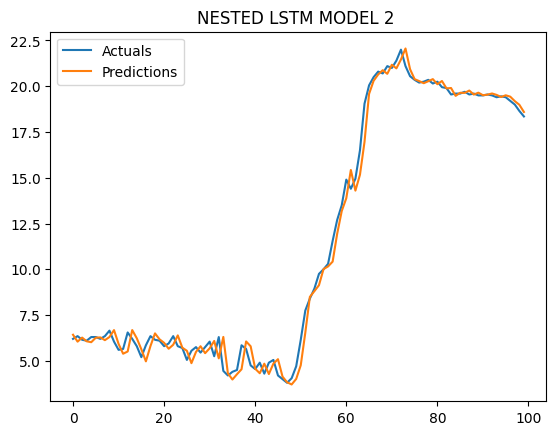

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Results3['Actuals'][:100], label='Actuals')
plt.plot(Results3['Predictions'][:100], label='Predictions')
plt.legend()
plt.title('NESTED LSTM MODEL 2 ')

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/Forcall22.csv"

val_df4 = pd.read_csv(csv_path)
val_df4



,Timestamp,Forcall
0,01/01/2021 00:00,2.8
1,01/01/2021 00:10,2.3
2,01/01/2021 00:20,2.2
3,01/01/2021 00:30,2.4
4,01/01/2021 00:40,2.5
...,...,...
21739,31/05/2021 23:10,17.6
21740,31/05/2021 23:20,17.3
21741,31/05/2021 23:30,17.1
21742,31/05/2021 23:40,16.9


In [ ]:
val_df4.index = pd.to_datetime(val_df4['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df4[:5]

,Timestamp,Forcall
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,2.8
2021-01-01 00:10:00,01/01/2021 00:10,2.3
2021-01-01 00:20:00,01/01/2021 00:20,2.2
2021-01-01 00:30:00,01/01/2021 00:30,2.4
2021-01-01 00:40:00,01/01/2021 00:40,2.5


<Axes: xlabel='Timestamp'>

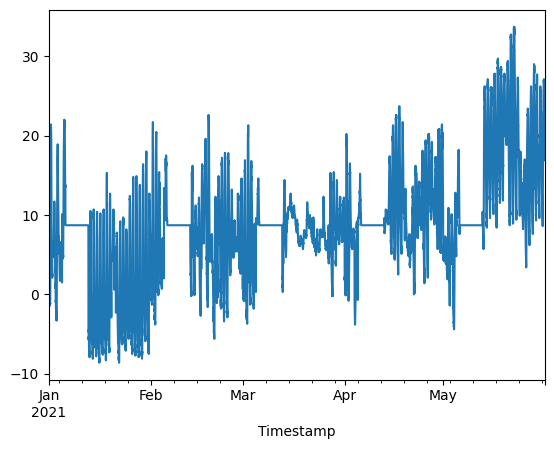

In [ ]:
val_df4 = val_df4['Forcall']
val_df4.plot()

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
num_rows = len(val_df4)
print("Number of rows:", num_rows)
val_df4.tail()

Number of rows: 21744


Timestamp
2021-05-31 23:10:00    17.6
2021-05-31 23:20:00    17.3
2021-05-31 23:30:00    17.1
2021-05-31 23:40:00    16.9
2021-05-31 23:50:00    16.9
Name: Forcall, dtype: float64

In [ ]:
# Assuming df_toX_y function extracts features (X) from the new data
WINDOW_SIZE = 5
X_new_data4, y_new_data4 = df_to_X_y(val_df4, WINDOW_SIZE)
# Access the shape of the features
X_new_data4.shape, y_new_data4.shape

((21739, 5, 1), (21739,))

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
Predictions4 = loaded_model.predict(X_new_data4).flatten()
rmse4 = sqrt(mean_squared_error(y_new_data4, Predictions4))
Results4 = pd.DataFrame(data={'Actuals':y_new_data4,'Predictions':Predictions4, 'RMSE': [rmse4] * len(y_new_data4)})
Results4

680/680 [==============================] - 3s 4ms/step


,Actuals,Predictions,RMSE
0,2.3,2.449755,1.557494
1,1.9,2.341857,1.557494
2,1.8,1.916142,1.557494
3,1.7,1.718212,1.557494
4,2.0,1.603156,1.557494
...,...,...,...
21734,17.6,17.601694,1.557494
21735,17.3,17.665775,1.557494
21736,17.1,17.273195,1.557494
21737,16.9,17.101377,1.557494


Text(0.5, 1.0, 'NESTED LSTM MODEL 2 ')

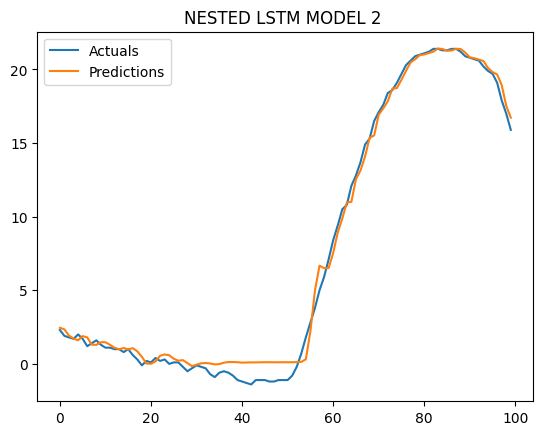

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Results4['Actuals'][:100], label='Actuals')
plt.plot(Results4['Predictions'][:100], label='Predictions')
plt.legend()
plt.title('NESTED LSTM MODEL 2 ')

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/Xodos22.csv"

val_df5 = pd.read_csv(csv_path)
val_df5



,Timestamp,Xodos
0,01/01/2021 00:00,16.4
1,01/01/2021 00:10,16.7
2,01/01/2021 00:20,17.1
3,01/01/2021 00:30,17.2
4,01/01/2021 00:40,17.2
...,...,...
21739,31/05/2021 23:10,17.7
21740,31/05/2021 23:20,17.7
21741,31/05/2021 23:30,18.0
21742,31/05/2021 23:40,17.9


In [ ]:
val_df5.index = pd.to_datetime(val_df5['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df5[:5]

,Timestamp,Xodos
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,16.4
2021-01-01 00:10:00,01/01/2021 00:10,16.7
2021-01-01 00:20:00,01/01/2021 00:20,17.1
2021-01-01 00:30:00,01/01/2021 00:30,17.2
2021-01-01 00:40:00,01/01/2021 00:40,17.2


<Axes: xlabel='Timestamp'>

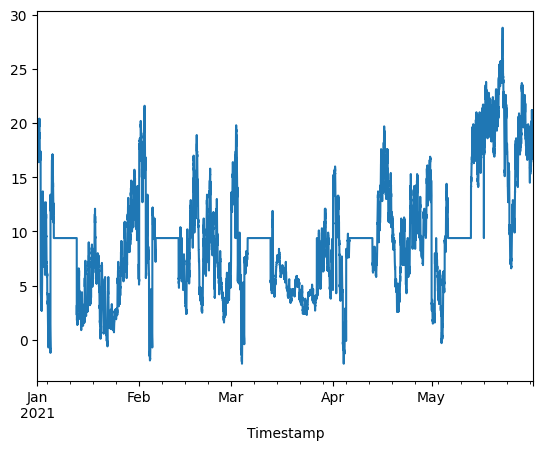

In [ ]:
val_df5 = val_df5['Xodos']
val_df5.plot()

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
num_rows = len(val_df5)
print("Number of rows:", num_rows)
val_df5.tail()

Number of rows: 21744


Timestamp
2021-05-31 23:10:00    17.7
2021-05-31 23:20:00    17.7
2021-05-31 23:30:00    18.0
2021-05-31 23:40:00    17.9
2021-05-31 23:50:00    17.7
Name: Xodos, dtype: float64

In [ ]:
# Assuming df_toX_y function extracts features (X) from the new data
WINDOW_SIZE = 5
X_new_data5, y_new_data5 = df_to_X_y(val_df5, WINDOW_SIZE)
# Access the shape of the features
X_new_data5.shape, y_new_data5.shape

((21739, 5, 1), (21739,))

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
Predictions5 = loaded_model.predict(X_new_data5).flatten()
rmse5 = sqrt(mean_squared_error(y_new_data5, Predictions5))
Results5 = pd.DataFrame(data={'Actuals':y_new_data5,'Predictions':Predictions5, 'RMSE': [rmse5] * len(y_new_data5)})
Results5

680/680 [==============================] - 3s 4ms/step


,Actuals,Predictions,RMSE
0,17.1,17.278248,0.450302
1,16.9,17.140881,0.450302
2,17.2,16.903538,0.450302
3,17.4,17.350124,0.450302
4,17.2,17.527494,0.450302
...,...,...,...
21734,17.7,18.008030,0.450302
21735,17.7,17.712793,0.450302
21736,18.0,17.770817,0.450302
21737,17.9,18.157516,0.450302


Text(0.5, 1.0, 'NESTED LSTM MODEL 2 ')

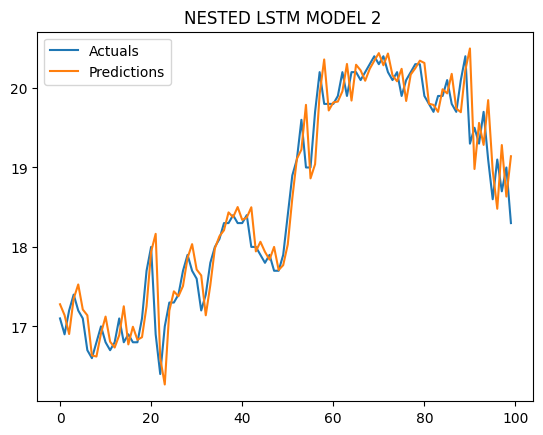

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Results5['Actuals'][:100], label='Actuals')
plt.plot(Results5['Predictions'][:100], label='Predictions')
plt.legend()
plt.title('NESTED LSTM MODEL 2 ')